# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run120', 'ORACLE.run138', 'ORACLE.run150', 'ORACLE.run18', 'ORACLE.run132', 'ORACLE.run144', 'ORACLE.run126', 'ORACLE.run114'}


{'Wisig_1', 'Wisig_2', 'Wisig_3', 'Wisig_4'}


tensor([[[-0.8050, -0.5750, -0.4408,  ...,  0.0000, -0.0767, -0.0575],
         [-0.0383, -0.5558,  1.2267,  ...,  0.0958,  1.2075,  1.0350]],

        [[ 0.7685,  1.2103,  0.4419,  ...,  1.0758,  1.3448,  0.6340],
         [-0.6724,  0.3650,  1.2487,  ...,  0.9029, -0.1921,  0.3458]],

        [[ 0.3968, -2.0408, -0.4535,  ..., -0.1134, -0.0945,  0.4724],
         [ 0.4157, -0.0945, -0.3590,  ..., -0.9826, -1.7007, -1.1149]],

        ...,

        [[ 1.2230,  0.7923, -0.1206,  ...,  0.6890, -0.2584,  0.2928],
         [-1.1885, -0.9818,  0.2411,  ..., -1.0679, -0.2928, -1.4986]],

        [[ 0.7245, -0.7076,  0.5054,  ..., -1.3816,  0.3370,  1.6174],
         [-0.2527,  0.8593, -0.2359,  ...,  0.8087,  0.5223, -0.2190]],

        [[-0.1196, -0.8200, -0.3587,  ...,  0.1025, -0.6662, -0.2904],
         [ 0.0171,  0.3075, -0.8029,  ..., -1.9133, -0.8029,  0.7346]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.4357, train_label_loss: 2.7858, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2975.8501, train_label_loss: 2.6910, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2951.0502, train_label_loss: 1.6188, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3005.5826, train_label_loss: 1.4803, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3003.1214, train_label_loss: 1.3145, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3003.7684, train_label_loss: 1.4256, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2949.6694, train_label_loss: 1.0471, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2924.8595, train_label_loss: 1.0231, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2963.4683, train_label_loss: 0.8299, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3404.6408, train_label_loss: 0.7414, 


epoch: 1, source_val_acc_label: 0.5390, target_val_acc_label: 0.6325, source_val_label_loss: 1.1957, target_val_label_loss: 4.9471, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.1700, train_label_loss: 0.6198, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3376.3536, train_label_loss: 1.7172, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3495.4365, train_label_loss: 1.4946, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3416.9614, train_label_loss: 0.8584, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3368.5446, train_label_loss: 0.5164, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3372.3209, train_label_loss: 1.2585, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3420.8200, train_label_loss: 1.4409, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3436.1163, train_label_loss: 0.6605, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3438.9184, train_label_loss: 0.5733, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3759.9634, train_label_loss: 0.8816, 


epoch: 2, source_val_acc_label: 0.5928, target_val_acc_label: 0.6775, source_val_label_loss: 1.0692, target_val_label_loss: 6.5343, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 3.5242, train_label_loss: 1.3698, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3821.8495, train_label_loss: 0.8350, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 4146.5137, train_label_loss: 0.6178, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 4415.2445, train_label_loss: 0.5688, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 4405.2293, train_label_loss: 0.6527, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3493.1764, train_label_loss: 1.0346, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3368.9750, train_label_loss: 0.6494, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3426.3134, train_label_loss: 0.5915, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3399.2156, train_label_loss: 1.0353, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3413.4240, train_label_loss: 0.4668, 


epoch: 3, source_val_acc_label: 0.5998, target_val_acc_label: 0.6819, source_val_label_loss: 1.0704, target_val_label_loss: 7.7877, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.1305, train_label_loss: 0.8691, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3614.8931, train_label_loss: 0.7891, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3868.1757, train_label_loss: 0.5501, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 4000.1299, train_label_loss: 0.7323, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 4004.1826, train_label_loss: 0.9326, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3845.1916, train_label_loss: 0.8793, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3879.2291, train_label_loss: 1.0593, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 4004.9652, train_label_loss: 0.7899, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3899.8700, train_label_loss: 0.7248, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3940.2788, train_label_loss: 0.8688, 


epoch: 4, source_val_acc_label: 0.6117, target_val_acc_label: 0.6861, source_val_label_loss: 1.0754, target_val_label_loss: 8.8253, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.8676, train_label_loss: 0.6419, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3983.0392, train_label_loss: 0.7396, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3961.7426, train_label_loss: 0.5730, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 4036.9708, train_label_loss: 0.2898, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3924.8874, train_label_loss: 0.6493, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3798.9267, train_label_loss: 0.5078, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3897.7226, train_label_loss: 0.5199, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3817.0211, train_label_loss: 0.1824, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3884.9844, train_label_loss: 0.4609, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3893.7054, train_label_loss: 0.5318, 


epoch: 5, source_val_acc_label: 0.6115, target_val_acc_label: 0.6930, source_val_label_loss: 1.1103, target_val_label_loss: 9.8740, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.9212, train_label_loss: 0.7610, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3926.9440, train_label_loss: 0.5865, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3923.9715, train_label_loss: 0.7871, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3825.2523, train_label_loss: 0.5306, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3924.1848, train_label_loss: 0.4488, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 4011.9344, train_label_loss: 0.2662, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3994.0187, train_label_loss: 0.8469, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 4038.9026, train_label_loss: 0.8568, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3873.9578, train_label_loss: 0.3473, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3570.6129, train_label_loss: 0.8565, 


epoch: 6, source_val_acc_label: 0.6032, target_val_acc_label: 0.6918, source_val_label_loss: 1.1790, target_val_label_loss: 11.2307, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.7591, train_label_loss: 0.6124, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2930.4785, train_label_loss: 0.3030, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2930.4712, train_label_loss: 0.9419, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2959.9980, train_label_loss: 0.4885, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2940.3503, train_label_loss: 0.7379, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3175.4320, train_label_loss: 0.8153, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3561.3094, train_label_loss: 0.2449, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3856.6896, train_label_loss: 0.6541, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3663.6825, train_label_loss: 0.5401, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3655.8233, train_label_loss: 0.6478, 


epoch: 7, source_val_acc_label: 0.6016, target_val_acc_label: 0.6870, source_val_label_loss: 1.2398, target_val_label_loss: 12.1416, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.0851, train_label_loss: 0.3072, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3462.7226, train_label_loss: 0.7095, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3014.7698, train_label_loss: 0.4279, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3049.1012, train_label_loss: 0.7353, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2958.9657, train_label_loss: 0.5256, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3022.6956, train_label_loss: 0.3105, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2991.1492, train_label_loss: 0.6141, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3009.2424, train_label_loss: 0.1597, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3085.1803, train_label_loss: 0.3771, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2949.2447, train_label_loss: 0.5927, 


epoch: 8, source_val_acc_label: 0.6062, target_val_acc_label: 0.6922, source_val_label_loss: 1.3262, target_val_label_loss: 13.3127, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.1156, train_label_loss: 0.5517, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3365.8630, train_label_loss: 0.3189, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3375.3135, train_label_loss: 0.3115, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3521.5708, train_label_loss: 0.4805, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3234.6821, train_label_loss: 0.3146, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3025.9746, train_label_loss: 0.2599, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2964.3519, train_label_loss: 0.3155, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2976.6004, train_label_loss: 0.3749, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2997.4641, train_label_loss: 0.2022, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2995.2693, train_label_loss: 0.5020, 


epoch: 9, source_val_acc_label: 0.6025, target_val_acc_label: 0.6933, source_val_label_loss: 1.4378, target_val_label_loss: 14.7662, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.7523, train_label_loss: 0.3807, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3368.9993, train_label_loss: 0.2765, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3460.4468, train_label_loss: 0.4067, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3376.5279, train_label_loss: 0.0748, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3390.2218, train_label_loss: 0.5384, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3423.2509, train_label_loss: 0.3696, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3451.0665, train_label_loss: 0.1983, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3603.9705, train_label_loss: 0.1281, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3077.3078, train_label_loss: 0.1485, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3030.8654, train_label_loss: 0.0646, 


epoch: 10, source_val_acc_label: 0.5942, target_val_acc_label: 0.6930, source_val_label_loss: 1.4821, target_val_label_loss: 15.4403, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.7501, train_label_loss: 0.2789, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3023.9771, train_label_loss: 0.1615, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3020.5385, train_label_loss: 0.3281, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2979.7626, train_label_loss: 0.3593, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3055.1454, train_label_loss: 0.1203, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3471.1793, train_label_loss: 0.5686, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3430.0907, train_label_loss: 0.2985, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3373.5250, train_label_loss: 0.1423, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3396.8179, train_label_loss: 0.4036, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3409.0776, train_label_loss: 0.1771, 


epoch: 11, source_val_acc_label: 0.6000, target_val_acc_label: 0.6913, source_val_label_loss: 1.5575, target_val_label_loss: 16.8744, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.1397, train_label_loss: 0.6890, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3086.3203, train_label_loss: 0.5962, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3343.1087, train_label_loss: 0.1747, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3349.4263, train_label_loss: 0.5938, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3333.4844, train_label_loss: 0.2959, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3386.9953, train_label_loss: 0.1096, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3486.7840, train_label_loss: 0.0515, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3492.2602, train_label_loss: 0.4061, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3948.1702, train_label_loss: 0.5690, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 4506.3614, train_label_loss: 0.5600, 


epoch: 12, source_val_acc_label: 0.5926, target_val_acc_label: 0.6926, source_val_label_loss: 1.6716, target_val_label_loss: 17.4558, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.1922, train_label_loss: 0.2650, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3400.6597, train_label_loss: 0.3794, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3364.3830, train_label_loss: 0.1410, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2992.4018, train_label_loss: 0.3982, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3035.8931, train_label_loss: 0.4173, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3026.6080, train_label_loss: 0.1167, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3091.5488, train_label_loss: 0.2439, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2975.6679, train_label_loss: 0.3037, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2989.4021, train_label_loss: 0.2579, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2976.0099, train_label_loss: 0.4457, 


epoch: 13, source_val_acc_label: 0.5875, target_val_acc_label: 0.6978, source_val_label_loss: 1.7102, target_val_label_loss: 18.1594, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.9453, train_label_loss: 0.0643, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3359.0892, train_label_loss: 0.1197, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3517.1572, train_label_loss: 0.0304, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3365.5118, train_label_loss: 0.2042, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3386.4140, train_label_loss: 0.1279, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3630.2576, train_label_loss: 0.1157, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3245.0642, train_label_loss: 0.1186, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3005.7709, train_label_loss: 0.2600, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3004.0431, train_label_loss: 0.0027, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2989.8107, train_label_loss: 0.0821, 


epoch: 14, source_val_acc_label: 0.5974, target_val_acc_label: 0.6900, source_val_label_loss: 1.7534, target_val_label_loss: 19.5690, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.7942, train_label_loss: 0.2442, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3078.4702, train_label_loss: 0.0580, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3060.9170, train_label_loss: 0.4152, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3417.0845, train_label_loss: 0.0392, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3470.2189, train_label_loss: 0.2925, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3394.8882, train_label_loss: 0.2138, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3437.6394, train_label_loss: 0.0083, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3376.4422, train_label_loss: 0.3618, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3344.3087, train_label_loss: 0.0933, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3689.7488, train_label_loss: 0.0556, 


epoch: 15, source_val_acc_label: 0.5926, target_val_acc_label: 0.6935, source_val_label_loss: 1.8653, target_val_label_loss: 20.7859, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.7948, train_label_loss: 0.1435, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2994.8625, train_label_loss: 0.3437, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3033.6829, train_label_loss: 0.6607, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3005.5374, train_label_loss: 0.3138, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3032.3544, train_label_loss: 0.1183, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3004.9364, train_label_loss: 0.1548, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3112.2425, train_label_loss: 0.1398, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3378.4574, train_label_loss: 0.1263, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3426.0204, train_label_loss: 0.0969, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3460.5272, train_label_loss: 0.2770, 


epoch: 16, source_val_acc_label: 0.5895, target_val_acc_label: 0.6960, source_val_label_loss: 1.8810, target_val_label_loss: 20.7000, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.4254, train_label_loss: 0.2711, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3773.7602, train_label_loss: 0.1390, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3437.4282, train_label_loss: 0.1359, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3485.0145, train_label_loss: 0.0052, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3788.9696, train_label_loss: 0.0082, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3961.4796, train_label_loss: 0.2403, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3121.3823, train_label_loss: 0.2381, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3009.2724, train_label_loss: 0.2747, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2992.3229, train_label_loss: 0.1691, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3011.0828, train_label_loss: 0.0066, 


epoch: 17, source_val_acc_label: 0.5999, target_val_acc_label: 0.6964, source_val_label_loss: 1.9096, target_val_label_loss: 21.8731, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

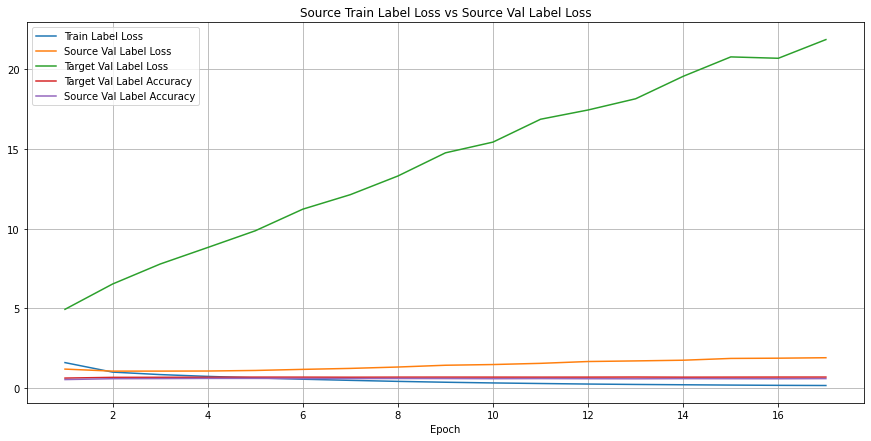

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

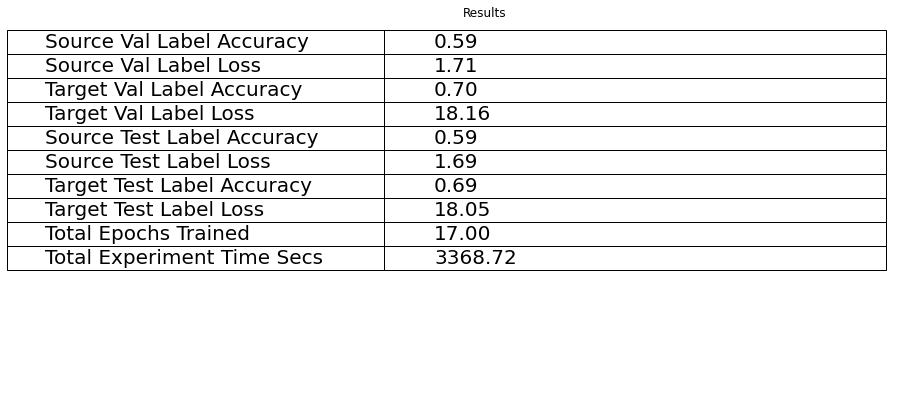

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

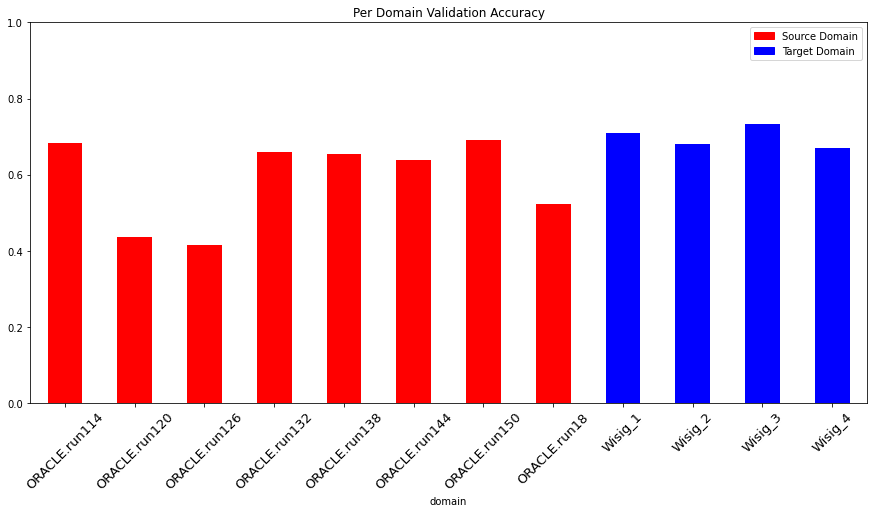

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5913411458333333 Target Test Label Accuracy: 0.6906346949327818
Source Val Label Accuracy: 0.5875325520833333 Target Val Label Accuracy: 0.6977848101265823


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}